In [1]:
import numpy as np
import networkx as nx
import time
from functools import partial
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.optimization.ising.max_cut import get_operator as get_maxcut_operator
from variationaltoolkit.objectives import maxcut_obj, modularity_obj
from variationaltoolkit import VariationalQuantumOptimizerSequential
from variationaltoolkit.operators import get_mis_w_penalty_operator

[2020-05-25 18:12:07,326] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\__init__.py:19} WARNING - Failed loading VariationalQuantumOptimizerAPOSMM, ignoring the following error: 'No module named 'mpi4py''


Can't find the mpsbackend module, continuing without it


# Let's solve maximum independent set on this graph

$G = K_{2,3}$

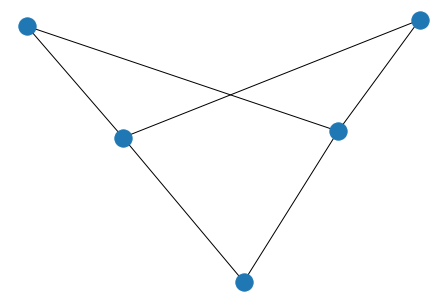

In [2]:
elist = [[0,2],[0,4],[1,2],[1,4],[0,3],[1,3]]

G = nx.OrderedGraph()
G.add_edges_from(elist)
vertex_num = G.number_of_nodes()
w = nx.adjacency_matrix(G, nodelist=range(vertex_num))
nx.draw(G)

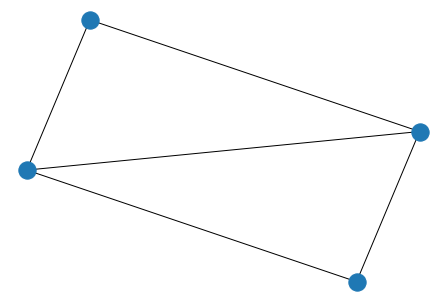

In [3]:
w2 = np.array([[0,1,1,0],[1,0,1,1],[1,1,0,1],[0,1,1,0]])
G2 = nx.from_numpy_matrix(w2)
nx.draw(G2)

In [4]:
import logging
from variationaltoolkit.utils import set_log_level
set_log_level(logging.INFO)

# set up the objective function for MIS QAOA+
def mis_w_penalty(x, G):
    obj = -sum(x)
    for i, j in G.edges():
        obj += (x[i] * x[j])
    return obj
obj = partial(mis_w_penalty, G=G)

# set up cost Hamiltonian
# call function from Qiskit
# can also set up the circuit version manually
C, offset = get_mis_w_penalty_operator(G)
print('Cost Hamiltonian is')
print(C.print_details())

# manually set up the mixer circuit
mixer_circuit = QuantumCircuit(vertex_num)
beta = Parameter('beta')
for q1 in range(vertex_num):
    mixer_circuit.h(q1)
    mixer_circuit.rz(2*beta, q1)
    mixer_circuit.h(q1)
print('mixer_circuit is')
print(mixer_circuit)
print()

# manually set up the initial state circuit
initial_state_circuit = QuantumCircuit(vertex_num)
# for i in range(vertex_num):
    # initial_state_circuit.h(i)
print('initial_state_circuit is')
print(initial_state_circuit)

p = 2
varopt = VariationalQuantumOptimizerSequential(
    obj,
    'COBYLA',
    initial_point=None,
    optimizer_parameters={'maxiter':1000},
    backend_description={'package':'qiskit', 'provider':'Aer', 'name':'qasm_simulator'},
    problem_description={'offset': offset},
    varform_description={
        'name':'QAOA',
        'p':p,
        'cost_operator':C,
        'num_qubits':vertex_num, 'use_mixer_qaoaplus':True,
        'mixer_circuit':mixer_circuit,
        'initial_state_circuit':initial_state_circuit,
    },
    execute_parameters={'shots': 5000}
    )

res = varopt.optimize()

[2020-05-25 18:12:07,751] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\objectivewrapper.py:79} INFO - called at step 0, objective: -0.835 at point [ 0.62475362  5.25429275  3.90588419 -3.47744583 -5.08842645]


Cost Hamiltonian is
IIIIZ	(-0.25+0j)
IIIZI	(-0.25+0j)
IIZIZ	(0.25+0j)
ZIIIZ	(0.25+0j)
IZIIZ	(0.25+0j)
IIZZI	(0.25+0j)
ZIIZI	(0.25+0j)
IZIZI	(0.25+0j)

mixer_circuit is
        ┌───┐┌────────────┐┌───┐
q_0: |0>┤ H ├┤ Rz(2*beta) ├┤ H ├
        ├───┤├────────────┤├───┤
q_1: |0>┤ H ├┤ Rz(2*beta) ├┤ H ├
        ├───┤├────────────┤├───┤
q_2: |0>┤ H ├┤ Rz(2*beta) ├┤ H ├
        ├───┤├────────────┤├───┤
q_3: |0>┤ H ├┤ Rz(2*beta) ├┤ H ├
        ├───┤├────────────┤├───┤
q_4: |0>┤ H ├┤ Rz(2*beta) ├┤ H ├
        └───┘└────────────┘└───┘

initial_state_circuit is
        
q_0: |0>
        
q_1: |0>
        
q_2: |0>
        
q_3: |0>
        
q_4: |0>
        
Checks out!


[2020-05-25 18:12:07,888] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\objectivewrapper.py:79} INFO - called at step 1, objective: -0.0068 at point [ 1.62475362  5.25429275  3.90588419 -3.47744583 -5.08842645]
[2020-05-25 18:12:08,021] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\objectivewrapper.py:79} INFO - called at step 2, objective: -0.7636 at point [ 0.62475362  6.25429275  3.90588419 -3.47744583 -5.08842645]
[2020-05-25 18:12:08,139] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\objectivewrapper.py:79} INFO - called at step 3, objective: -0.7536 at point [ 0.62475362  5.25429275  4.90588419 -3.47744583 -5.08842645]
[2020-05-25 18:12:08,266] {c:\users\kevin gui\desktop\variationaltoolkit\variationaltoolkit\objectivewrapper.py:79} INFO - called at step 4, objective: -0.7814 at point [ 0.62475362  5.25429275  3.90588419 -2.47744583 -5.08842645]
[2020-05-25 18:12:08,388] {c:\users\kevin gui\desktop\variationaltoolkit\var

In [5]:
print(res)

{'num_optimizer_evals': 75, 'min_val': -2.8822, 'opt_params': array([-0.8123161 ,  4.71161889,  3.96956411, -3.14397574, -3.47109598])}


In [6]:
optimum, counts = varopt.get_optimal_solution(return_counts=True)
print(counts)
print(f"Found optimal solution: {optimum}")

Counter({'11100': 4692, '11101': 50, '11110': 41, '01110': 39, '10101': 37, '10110': 36, '11010': 32, '01101': 31, '11001': 30, '11111': 3, '10011': 2, '01111': 2, '11011': 2, '10000': 1, '01000': 1, '10111': 1})
Found optimal solution: (-3, array([1, 1, 1, 0, 0]))


Counter({'11100': 4692, '11101': 50, '11110': 41, '01110': 39, '10101': 37, '10110': 36, '11010': 32, '01101': 31, '11001': 30, '11111': 3, '10011': 2, '01111': 2, '11011': 2, '10000': 1, '01000': 1, '10111': 1})


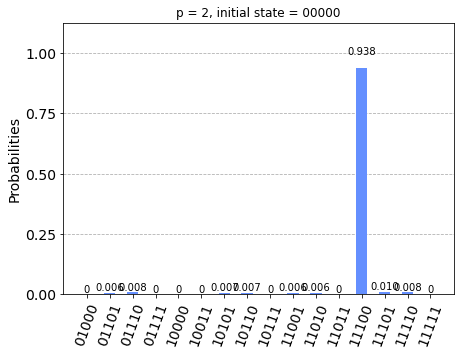

In [7]:
from qiskit.tools.visualization import plot_histogram
print(counts)
plot_histogram(counts, title= 'p = ' + str(p) + ', initial state = 00000')